In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def gaussian_kernel(X, krnl_sigma=0.3): # too low values return nan loss
    norms = (X**2).sum(dim=1, keepdim=True)
    dists_sq = norms + norms.T - 2.0 * torch.mm(X, X.T)
    K = torch.exp(-dists_sq / (2 * (krnl_sigma**2))) / (math.sqrt(2 * math.pi * krnl_sigma**2))
    return K

# def rbf(x):
#         x = x - x.T
#         return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

def rbf(X, krnl_sigma=0.1):
    norms = (X**2).sum(dim=1, keepdim=True)
    dists_sq = norms + norms.T - 2.0 * torch.mm(X, X.T)
    K = torch.exp(-dists_sq / (2 * (krnl_sigma**2)))
    return K

# def cauchy(x):
#         x = x - x.T
#         return  1. / (krnl_sigma*(x**2) + 1)
    
def cauchy(X, krnl_sigma=0.1):
    norms = (X**2).sum(dim=1, keepdim=True)
    dists_sq = norms + norms.T - 2.0 * torch.mm(X, X.T)
    K = 1. / (krnl_sigma * dists_sq + 1)
    return K


In [4]:
def standardize_dataset(dataset):
    features = torch.vstack([dataset[i][0] for i in range(len(dataset))])
    targets = torch.vstack([dataset[i][1] for i in range(len(dataset))])
    print(features.shape)
    print(targets.shape)
    
    features_mean = features.mean(dim=0)
    features_std = features.std(dim=0)
    targets_mean = targets.mean(dim=0)
    targets_std = targets.std(dim=0)
    
    features_std[features_std == 0] = 1
    targets_std[targets_std == 0] = 1
    
    standardized_features = (features - features_mean) / features_std
    standardized_targets = (targets - targets_mean) / targets_std
    
    standardized_dataset = TensorDataset(standardized_features, standardized_targets)
    
    return standardized_dataset
    
    
    
    

In [5]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy")

In [6]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), train_size = 5, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [7]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 59
# the rest is arbitrary
hidden_dim_feat = 512
hidden_dim_target = 24
output_dim = 2
num_epochs = 10000


In [8]:
temperature = 0.05
base_temperature = 0.05 # too low values return nan loss
lr = 0.001 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 3 # too low values return nan loss

In [9]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([5, 499500])
torch.Size([5, 59])
torch.Size([142, 499500])
torch.Size([142, 59])


In [10]:

model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
criterion = KernelizedSupCon(method='expw', temperature=temperature, base_temperature=base_temperature, kernel=kernel)
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat, out_target = model(features, targets)
        loss = criterion(out_feat, out_target)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)


Epoch 0 | Mean Loss 1.5163054466247559
Epoch 1 | Mean Loss 6.450692772865295
Epoch 2 | Mean Loss 0.9639293700456619
Epoch 3 | Mean Loss 6.988452911376953
Epoch 4 | Mean Loss 9.181048870084851
Epoch 5 | Mean Loss 3.789790630340576
Epoch 6 | Mean Loss 0.4738505482673645
Epoch 7 | Mean Loss 0.05336527153849602
Epoch 8 | Mean Loss 3.2401371151208878
Epoch 9 | Mean Loss 1.4424216747283936
Epoch 10 | Mean Loss 0.014185627922415733
Epoch 11 | Mean Loss 0.08696221560239792
Epoch 12 | Mean Loss 0.5686525106430054
Epoch 13 | Mean Loss 1.8818855285644531
Epoch 14 | Mean Loss 0.06606590747833252
Epoch 15 | Mean Loss 1.3428170680999756
Epoch 16 | Mean Loss 0.49363398551895443
Epoch 17 | Mean Loss 0.18743927776813507
Epoch 18 | Mean Loss 2.162790298461914
Epoch 19 | Mean Loss 0.6514807641506195
Epoch 20 | Mean Loss 0.8582402467727661
Epoch 21 | Mean Loss 0.06353002786636353
Epoch 22 | Mean Loss 0.13572466373443604
Epoch 23 | Mean Loss 0.13663916289806366
Epoch 24 | Mean Loss 0.2613906264305115
Epoch

Epoch 201 | Mean Loss 0.13854330778121948
Epoch 202 | Mean Loss 0.7237332463264465
Epoch 203 | Mean Loss 0.7400745749473572
Epoch 204 | Mean Loss 0.29660505056381226
Epoch 205 | Mean Loss 0.049053944647312164
Epoch 206 | Mean Loss 0.5020830631256104
Epoch 207 | Mean Loss 0.21820256114006042
Epoch 208 | Mean Loss 0.49137604236602783
Epoch 209 | Mean Loss 0.09459662437438965
Epoch 210 | Mean Loss 0.104573093354702
Epoch 211 | Mean Loss 0.3228933811187744
Epoch 212 | Mean Loss 0.290483295917511
Epoch 213 | Mean Loss 0.09321348369121552
Epoch 214 | Mean Loss 0.26337459683418274
Epoch 215 | Mean Loss 0.19415578246116638
Epoch 216 | Mean Loss 0.1402876377105713
Epoch 217 | Mean Loss 0.09731261432170868
Epoch 218 | Mean Loss 0.09020476788282394
Epoch 219 | Mean Loss 0.07275482267141342
Epoch 220 | Mean Loss 0.12582434341311455
Epoch 221 | Mean Loss 0.10360051598399878
Epoch 222 | Mean Loss 0.6437382698059082
Epoch 223 | Mean Loss 0.49602895975112915
Epoch 224 | Mean Loss 0.15262871980667114
E

Epoch 399 | Mean Loss 0.05737505480647087
Epoch 400 | Mean Loss 0.17803081590682268
Epoch 401 | Mean Loss 0.07644283771514893
Epoch 402 | Mean Loss 0.06033007800579071
Epoch 403 | Mean Loss 0.01423625461757183
Epoch 404 | Mean Loss 0.04996022209525108
Epoch 405 | Mean Loss 0.13349851965904236
Epoch 406 | Mean Loss 0.04844728857278824
Epoch 407 | Mean Loss 0.029730331152677536
Epoch 408 | Mean Loss 0.04048651084303856
Epoch 409 | Mean Loss 0.035684432834386826
Epoch 410 | Mean Loss 0.030616655945777893
Epoch 411 | Mean Loss 0.24954721331596375
Epoch 412 | Mean Loss 0.01864100992679596
Epoch 413 | Mean Loss 0.12541769444942474
Epoch 414 | Mean Loss 0.19641920924186707
Epoch 415 | Mean Loss 0.013392887078225613
Epoch 416 | Mean Loss 0.13082738919183612
Epoch 417 | Mean Loss 0.014280076138675213
Epoch 418 | Mean Loss 0.020574524998664856
Epoch 419 | Mean Loss 0.12407615780830383
Epoch 420 | Mean Loss 0.01063685305416584
Epoch 421 | Mean Loss 0.12416037172079086
Epoch 422 | Mean Loss 0.0943

Epoch 594 | Mean Loss 0.00321159977465868
Epoch 595 | Mean Loss 0.0144681287192725
Epoch 596 | Mean Loss 0.0058689480647444725
Epoch 597 | Mean Loss 0.007960345596075058
Epoch 598 | Mean Loss 0.01959577575325966
Epoch 599 | Mean Loss 0.0044720228761434555
Epoch 600 | Mean Loss 0.012424438260495663
Epoch 601 | Mean Loss 0.009801691398024559
Epoch 602 | Mean Loss 0.009333498775959015
Epoch 603 | Mean Loss 0.15227022883482277
Epoch 604 | Mean Loss 0.024686597753316164
Epoch 605 | Mean Loss 0.0038157401140779257
Epoch 606 | Mean Loss 0.009852999821305275
Epoch 607 | Mean Loss 0.006438173353672028
Epoch 608 | Mean Loss 0.0034987130202353
Epoch 609 | Mean Loss 0.019811073318123817
Epoch 610 | Mean Loss 0.006261277478188276
Epoch 611 | Mean Loss 0.0070007010363042355
Epoch 612 | Mean Loss 0.006990616209805012
Epoch 613 | Mean Loss 0.006726914085447788
Epoch 614 | Mean Loss 0.014204880222678185
Epoch 615 | Mean Loss 0.01101674884557724
Epoch 616 | Mean Loss 0.0037192520685493946
Epoch 617 | Me

Epoch 786 | Mean Loss 0.002203018171712756
Epoch 787 | Mean Loss 0.007119899149984121
Epoch 788 | Mean Loss 0.004151519387960434
Epoch 789 | Mean Loss 0.0035331430844962597
Epoch 790 | Mean Loss 0.0021755434572696686
Epoch 791 | Mean Loss 0.0034661409445106983
Epoch 792 | Mean Loss 0.006552506703885186
Epoch 793 | Mean Loss 0.006442828569561243
Epoch 794 | Mean Loss 0.009048499166965485
Epoch 795 | Mean Loss 0.00243098521605134
Epoch 796 | Mean Loss 0.002180455019697547
Epoch 797 | Mean Loss 0.003291768953204155
Epoch 798 | Mean Loss 0.008403176441788673
Epoch 799 | Mean Loss 0.0021701217629015446
Epoch 800 | Mean Loss 0.008291445672512054
Epoch 801 | Mean Loss 0.0031552892178297043
Epoch 802 | Mean Loss 0.0030849347822368145
Epoch 803 | Mean Loss 0.005938507383688396
Epoch 804 | Mean Loss 0.0024436363019049168
Epoch 805 | Mean Loss 0.002826377749443054
Epoch 806 | Mean Loss 0.06063709408044815
Epoch 807 | Mean Loss 0.00807997491210699
Epoch 808 | Mean Loss 0.002155393362045288
Epoch 8

Epoch 978 | Mean Loss 0.009402528405189514
Epoch 979 | Mean Loss 0.004702770616859198
Epoch 980 | Mean Loss 0.007161320187151432
Epoch 981 | Mean Loss 0.00885478314012289
Epoch 982 | Mean Loss 0.004734592046588659
Epoch 983 | Mean Loss 0.200701043009758
Epoch 984 | Mean Loss 0.20533421635627747
Epoch 985 | Mean Loss 0.004834076389670372
Epoch 986 | Mean Loss 0.04344906425103545
Epoch 987 | Mean Loss 0.030185353010892868
Epoch 988 | Mean Loss 0.004649116192013025
Epoch 989 | Mean Loss 0.03229419142007828
Epoch 990 | Mean Loss 0.005739632062613964
Epoch 991 | Mean Loss 0.007272685877978802
Epoch 992 | Mean Loss 0.034149445593357086
Epoch 993 | Mean Loss 0.03576185181736946
Epoch 994 | Mean Loss 0.03021952323615551
Epoch 995 | Mean Loss 0.026147162541747093
Epoch 996 | Mean Loss 0.004204735159873962
Epoch 997 | Mean Loss 0.1259865164756775
Epoch 998 | Mean Loss 0.11912491172552109
Epoch 999 | Mean Loss 0.017548270523548126
Epoch 1000 | Mean Loss 0.11693546175956726
Epoch 1001 | Mean Loss 

Epoch 1167 | Mean Loss 0.0027280901558697224
Epoch 1168 | Mean Loss 0.0035508021246641874
Epoch 1169 | Mean Loss 0.0058698575012385845
Epoch 1170 | Mean Loss 0.00303214555606246
Epoch 1171 | Mean Loss 0.0022818241268396378
Epoch 1172 | Mean Loss 0.007007299922406673
Epoch 1173 | Mean Loss 0.005532423034310341
Epoch 1174 | Mean Loss 0.002756345784291625
Epoch 1175 | Mean Loss 0.08761107921600342
Epoch 1176 | Mean Loss 0.0035348765086382627
Epoch 1177 | Mean Loss 0.006126557942479849
Epoch 1178 | Mean Loss 0.002371258568018675
Epoch 1179 | Mean Loss 0.005574456881731749
Epoch 1180 | Mean Loss 0.006055568810552359
Epoch 1181 | Mean Loss 0.0035571239423006773
Epoch 1182 | Mean Loss 0.002484327182173729
Epoch 1183 | Mean Loss 0.0045077139511704445
Epoch 1184 | Mean Loss 0.08052738755941391
Epoch 1185 | Mean Loss 0.0022613948676735163
Epoch 1186 | Mean Loss 0.0024253970477730036
Epoch 1187 | Mean Loss 0.0028128214180469513
Epoch 1188 | Mean Loss 0.005955795757472515
Epoch 1189 | Mean Loss 0.

Epoch 1353 | Mean Loss 0.003226206172257662
Epoch 1354 | Mean Loss 0.0028908317908644676
Epoch 1355 | Mean Loss 0.0063498239032924175
Epoch 1356 | Mean Loss 0.002530815079808235
Epoch 1357 | Mean Loss 0.004443156998604536
Epoch 1358 | Mean Loss 0.0022914553992450237
Epoch 1359 | Mean Loss 0.002438156632706523
Epoch 1360 | Mean Loss 0.0022184792906045914
Epoch 1361 | Mean Loss 0.014360307715833187
Epoch 1362 | Mean Loss 0.0033763430546969175
Epoch 1363 | Mean Loss 0.004172775894403458
Epoch 1364 | Mean Loss 0.0030131032690405846
Epoch 1365 | Mean Loss 0.0021063850726932287
Epoch 1366 | Mean Loss 0.002094330731779337
Epoch 1367 | Mean Loss 0.004072609823197126
Epoch 1368 | Mean Loss 0.002427058294415474
Epoch 1369 | Mean Loss 0.0030070915818214417
Epoch 1370 | Mean Loss 0.0022032265551388264
Epoch 1371 | Mean Loss 0.002184512559324503
Epoch 1372 | Mean Loss 0.0020654508844017982
Epoch 1373 | Mean Loss 0.0024187061935663223
Epoch 1374 | Mean Loss 0.003911847248673439
Epoch 1375 | Mean Los

Epoch 1539 | Mean Loss 0.002468584105372429
Epoch 1540 | Mean Loss 0.002350655384361744
Epoch 1541 | Mean Loss 0.002342709805816412
Epoch 1542 | Mean Loss 0.005606657825410366
Epoch 1543 | Mean Loss 0.002415071241557598
Epoch 1544 | Mean Loss 0.002846939256414771
Epoch 1545 | Mean Loss 0.0023422695230692625
Epoch 1546 | Mean Loss 0.0020383219234645367
Epoch 1547 | Mean Loss 0.0023257890716195107
Epoch 1548 | Mean Loss 0.0023362073116004467
Epoch 1549 | Mean Loss 0.0023224023170769215
Epoch 1550 | Mean Loss 0.002041254658252001
Epoch 1551 | Mean Loss 0.005101379007101059
Epoch 1552 | Mean Loss 0.002253907499834895
Epoch 1553 | Mean Loss 0.002300550229847431
Epoch 1554 | Mean Loss 0.0022212392650544643
Epoch 1555 | Mean Loss 0.004822477698326111
Epoch 1556 | Mean Loss 0.0020269707310944796
Epoch 1557 | Mean Loss 0.002130805980414152
Epoch 1558 | Mean Loss 0.0028739124536514282
Epoch 1559 | Mean Loss 0.0034736839588731527
Epoch 1560 | Mean Loss 0.0021120733581483364
Epoch 1561 | Mean Loss

Epoch 1725 | Mean Loss 0.003583594923838973
Epoch 1726 | Mean Loss 0.02507299743592739
Epoch 1727 | Mean Loss 0.002364025916904211
Epoch 1728 | Mean Loss 0.011490024626255035
Epoch 1729 | Mean Loss 0.04152101278305054
Epoch 1730 | Mean Loss 0.050361521542072296
Epoch 1731 | Mean Loss 0.002997548785060644
Epoch 1732 | Mean Loss 0.00687004067003727
Epoch 1733 | Mean Loss 0.002768309786915779
Epoch 1734 | Mean Loss 0.0024485383182764053
Epoch 1735 | Mean Loss 0.011055580340325832
Epoch 1736 | Mean Loss 0.4488447904586792
Epoch 1737 | Mean Loss 0.0198161993175745
Epoch 1738 | Mean Loss 0.11388681828975677
Epoch 1739 | Mean Loss 0.042891617864370346
Epoch 1740 | Mean Loss 0.003329912666231394
Epoch 1741 | Mean Loss 2.4610320329666138
Epoch 1742 | Mean Loss 1.0003993511199951
Epoch 1743 | Mean Loss 0.3884105384349823
Epoch 1744 | Mean Loss 0.46101829409599304
Epoch 1745 | Mean Loss 0.1328563094139099
Epoch 1746 | Mean Loss 0.044910967350006104
Epoch 1747 | Mean Loss 0.18850523233413696
Epoch

Epoch 1917 | Mean Loss 0.02335762046277523
Epoch 1918 | Mean Loss 0.014146856963634491
Epoch 1919 | Mean Loss 0.002349512418732047
Epoch 1920 | Mean Loss 0.02046387642621994
Epoch 1921 | Mean Loss 0.005020259413868189
Epoch 1922 | Mean Loss 0.008426359854638577
Epoch 1923 | Mean Loss 0.008073944598436356
Epoch 1924 | Mean Loss 0.0031377431005239487
Epoch 1925 | Mean Loss 0.012472763657569885
Epoch 1926 | Mean Loss 0.0022664975840598345
Epoch 1927 | Mean Loss 0.003071404993534088
Epoch 1928 | Mean Loss 0.016606222838163376
Epoch 1929 | Mean Loss 0.0054070125333964825
Epoch 1930 | Mean Loss 0.002232590690255165
Epoch 1931 | Mean Loss 0.005884641315788031
Epoch 1932 | Mean Loss 0.011508452706038952
Epoch 1933 | Mean Loss 0.002212704159319401
Epoch 1934 | Mean Loss 0.011010974645614624
Epoch 1935 | Mean Loss 0.014133363962173462
Epoch 1936 | Mean Loss 0.005799354054033756
Epoch 1937 | Mean Loss 0.01011581439524889
Epoch 1938 | Mean Loss 0.009820181876420975
Epoch 1939 | Mean Loss 0.0031501

Epoch 2103 | Mean Loss 0.010991059243679047
Epoch 2104 | Mean Loss 0.0040238481014966965
Epoch 2105 | Mean Loss 0.002501990180462599
Epoch 2106 | Mean Loss 0.0022898875176906586
Epoch 2107 | Mean Loss 0.0020336126908659935
Epoch 2108 | Mean Loss 0.002466019941493869
Epoch 2109 | Mean Loss 0.0020353791769593954
Epoch 2110 | Mean Loss 0.010551570914685726
Epoch 2111 | Mean Loss 0.004534296691417694
Epoch 2112 | Mean Loss 0.002662768354639411
Epoch 2113 | Mean Loss 0.002694057999178767
Epoch 2114 | Mean Loss 0.006024698726832867
Epoch 2115 | Mean Loss 0.0038186251185834408
Epoch 2116 | Mean Loss 0.0038033146411180496
Epoch 2117 | Mean Loss 0.002411715453490615
Epoch 2118 | Mean Loss 0.004467274993658066
Epoch 2119 | Mean Loss 0.0037369343917816877
Epoch 2120 | Mean Loss 0.003710911376401782
Epoch 2121 | Mean Loss 0.010115714743733406
Epoch 2122 | Mean Loss 0.0026440180372446775
Epoch 2123 | Mean Loss 0.0020418690983206034
Epoch 2124 | Mean Loss 0.005957949906587601
Epoch 2125 | Mean Loss 

Epoch 2289 | Mean Loss 0.007349382620304823
Epoch 2290 | Mean Loss 0.0029097904916852713
Epoch 2291 | Mean Loss 0.002207194920629263
Epoch 2292 | Mean Loss 0.0021958460565656424
Epoch 2293 | Mean Loss 0.0037813715171068907
Epoch 2294 | Mean Loss 0.007758637890219688
Epoch 2295 | Mean Loss 0.006674949079751968
Epoch 2296 | Mean Loss 0.006304729264229536
Epoch 2297 | Mean Loss 0.0020687789656221867
Epoch 2298 | Mean Loss 0.002856775652730903
Epoch 2299 | Mean Loss 0.002062923740595579
Epoch 2300 | Mean Loss 0.0025594967883080244
Epoch 2301 | Mean Loss 0.004624153487384319
Epoch 2302 | Mean Loss 0.004357250872995877
Epoch 2303 | Mean Loss 0.0021587498486042023
Epoch 2304 | Mean Loss 0.003862837329506874
Epoch 2305 | Mean Loss 0.002049400471150875
Epoch 2306 | Mean Loss 0.01008499413728714
Epoch 2307 | Mean Loss 0.00890230480581522
Epoch 2308 | Mean Loss 0.003305695718154311
Epoch 2309 | Mean Loss 0.008794574066996574
Epoch 2310 | Mean Loss 0.0020561516284942627
Epoch 2311 | Mean Loss 0.00

Epoch 2475 | Mean Loss 0.0024907891638576984
Epoch 2476 | Mean Loss 0.002665129257366061
Epoch 2477 | Mean Loss 0.0023177671246230602
Epoch 2478 | Mean Loss 0.002091086469590664
Epoch 2479 | Mean Loss 0.005388082005083561
Epoch 2480 | Mean Loss 0.005331709980964661
Epoch 2481 | Mean Loss 0.002063389867544174
Epoch 2482 | Mean Loss 0.0026848292909562588
Epoch 2483 | Mean Loss 0.002655022544786334
Epoch 2484 | Mean Loss 0.002586786402389407
Epoch 2485 | Mean Loss 0.0037082680501043797
Epoch 2486 | Mean Loss 0.002055251970887184
Epoch 2487 | Mean Loss 0.002064943313598633
Epoch 2488 | Mean Loss 0.003396510612219572
Epoch 2489 | Mean Loss 0.0022501996718347073
Epoch 2490 | Mean Loss 0.0021656507160514593
Epoch 2491 | Mean Loss 0.0020975745283067226
Epoch 2492 | Mean Loss 0.002077737357467413
Epoch 2493 | Mean Loss 0.0020960881374776363
Epoch 2494 | Mean Loss 0.002073751762509346
Epoch 2495 | Mean Loss 0.0020938001107424498
Epoch 2496 | Mean Loss 0.0021294967737048864
Epoch 2497 | Mean Loss

Epoch 2661 | Mean Loss 0.0025994419120252132
Epoch 2662 | Mean Loss 0.002026996575295925
Epoch 2663 | Mean Loss 0.0021169823594391346
Epoch 2664 | Mean Loss 0.002460051327943802
Epoch 2665 | Mean Loss 0.0023290319368243217
Epoch 2666 | Mean Loss 0.002445183228701353
Epoch 2667 | Mean Loss 0.002322159707546234
Epoch 2668 | Mean Loss 0.0020469033624976873
Epoch 2669 | Mean Loss 0.0023129046894041494
Epoch 2670 | Mean Loss 0.002027860376983881
Epoch 2671 | Mean Loss 0.0033662214409559965
Epoch 2672 | Mean Loss 0.0020370734855532646
Epoch 2673 | Mean Loss 0.002563158981502056
Epoch 2674 | Mean Loss 0.002047092653810978
Epoch 2675 | Mean Loss 0.0021813008934259415
Epoch 2676 | Mean Loss 0.0021119527518749237
Epoch 2677 | Mean Loss 0.0023058110382407904
Epoch 2678 | Mean Loss 0.0021587698720395565
Epoch 2679 | Mean Loss 0.002025926485657692
Epoch 2680 | Mean Loss 0.002528439275920391
Epoch 2681 | Mean Loss 0.002046470530331135
Epoch 2682 | Mean Loss 0.0024190135300159454
Epoch 2683 | Mean Lo

Epoch 2847 | Mean Loss 0.00234824582003057
Epoch 2848 | Mean Loss 0.0020648955833166838
Epoch 2849 | Mean Loss 0.0021986854262650013
Epoch 2850 | Mean Loss 0.002015115227550268
Epoch 2851 | Mean Loss 0.0023397416807711124
Epoch 2852 | Mean Loss 0.0027620214968919754
Epoch 2853 | Mean Loss 0.0027538714930415154
Epoch 2854 | Mean Loss 0.0023293932899832726
Epoch 2855 | Mean Loss 0.0022291128989309072
Epoch 2856 | Mean Loss 0.002061990089714527
Epoch 2857 | Mean Loss 0.0024080919101834297
Epoch 2858 | Mean Loss 0.002061572391539812
Epoch 2859 | Mean Loss 0.0023128134198486805
Epoch 2860 | Mean Loss 0.0023076520301401615
Epoch 2861 | Mean Loss 0.0022998161148279905
Epoch 2862 | Mean Loss 0.0020852284505963326
Epoch 2863 | Mean Loss 0.0021014264784753323
Epoch 2864 | Mean Loss 0.0022502359934151173
Epoch 2865 | Mean Loss 0.0020973030477762222
Epoch 2866 | Mean Loss 0.002366507425904274
Epoch 2867 | Mean Loss 0.0022667068988084793
Epoch 2868 | Mean Loss 0.002074447926133871
Epoch 2869 | Mean

Epoch 3033 | Mean Loss 0.0020684851333498955
Epoch 3034 | Mean Loss 0.0020840379875153303
Epoch 3035 | Mean Loss 0.0020670327357947826
Epoch 3036 | Mean Loss 0.00227365642786026
Epoch 3037 | Mean Loss 0.0028518284671008587
Epoch 3038 | Mean Loss 0.0020548931788653135
Epoch 3039 | Mean Loss 0.0020895495545119047
Epoch 3040 | Mean Loss 0.0020279493182897568
Epoch 3041 | Mean Loss 0.0020245618652552366
Epoch 3042 | Mean Loss 0.0022670519538223743
Epoch 3043 | Mean Loss 0.0021075038239359856
Epoch 3044 | Mean Loss 0.002260899404063821
Epoch 3045 | Mean Loss 0.0020217616111040115
Epoch 3046 | Mean Loss 0.0022510529961436987
Epoch 3047 | Mean Loss 0.0021455599926412106
Epoch 3048 | Mean Loss 0.002145074773579836
Epoch 3049 | Mean Loss 0.002070035319775343
Epoch 3050 | Mean Loss 0.0020667873322963715
Epoch 3051 | Mean Loss 0.0022327853366732597
Epoch 3052 | Mean Loss 0.0020710385870188475
Epoch 3053 | Mean Loss 0.0020251180976629257
Epoch 3054 | Mean Loss 0.002020793966948986
Epoch 3055 | Mea

Epoch 3219 | Mean Loss 0.002078430727124214
Epoch 3220 | Mean Loss 0.0021417064126580954
Epoch 3221 | Mean Loss 0.002071916591376066
Epoch 3222 | Mean Loss 0.0027754546608775854
Epoch 3223 | Mean Loss 0.002137660514563322
Epoch 3224 | Mean Loss 0.002723347395658493
Epoch 3225 | Mean Loss 0.0020276913419365883
Epoch 3226 | Mean Loss 0.0020245942287147045
Epoch 3227 | Mean Loss 0.00214654509909451
Epoch 3228 | Mean Loss 0.0020719817839562893
Epoch 3229 | Mean Loss 0.002017738064751029
Epoch 3230 | Mean Loss 0.0020704632624983788
Epoch 3231 | Mean Loss 0.002191828330978751
Epoch 3232 | Mean Loss 0.0020514477510005236
Epoch 3233 | Mean Loss 0.002127410378307104
Epoch 3234 | Mean Loss 0.0021144766360521317
Epoch 3235 | Mean Loss 0.0021799332462251186
Epoch 3236 | Mean Loss 0.002141485456377268
Epoch 3237 | Mean Loss 0.0021179767791181803
Epoch 3238 | Mean Loss 0.002067095134407282
Epoch 3239 | Mean Loss 0.0021396540105342865
Epoch 3240 | Mean Loss 0.002065689070150256
Epoch 3241 | Mean Loss

Epoch 3405 | Mean Loss 0.0021612346172332764
Epoch 3406 | Mean Loss 0.002014453522861004
Epoch 3407 | Mean Loss 0.0024663980584591627
Epoch 3408 | Mean Loss 0.002056737896054983
Epoch 3409 | Mean Loss 0.0021464969031512737
Epoch 3410 | Mean Loss 0.002453687135130167
Epoch 3411 | Mean Loss 0.002036724705249071
Epoch 3412 | Mean Loss 0.002437535673379898
Epoch 3413 | Mean Loss 0.002144512953236699
Epoch 3414 | Mean Loss 0.002416408620774746
Epoch 3415 | Mean Loss 0.00205501401796937
Epoch 3416 | Mean Loss 0.0020451899617910385
Epoch 3417 | Mean Loss 0.002072741976007819
Epoch 3418 | Mean Loss 0.0020537120290100574
Epoch 3419 | Mean Loss 0.002004615031182766
Epoch 3420 | Mean Loss 0.002024400746449828
Epoch 3421 | Mean Loss 0.0021860380656946177
Epoch 3422 | Mean Loss 0.002052729483693838
Epoch 3423 | Mean Loss 0.0024260166101157665
Epoch 3424 | Mean Loss 0.0021853726357221603
Epoch 3425 | Mean Loss 0.0022224660497158766
Epoch 3426 | Mean Loss 0.002357170917093754
Epoch 3427 | Mean Loss 0

Epoch 3591 | Mean Loss 0.4630385469645262
Epoch 3592 | Mean Loss 0.29511725864722393
Epoch 3593 | Mean Loss 1.097360372543335
Epoch 3594 | Mean Loss 0.26086078165099025
Epoch 3595 | Mean Loss 0.45821984112262726
Epoch 3596 | Mean Loss 0.43094611167907715
Epoch 3597 | Mean Loss 0.37472616508603096
Epoch 3598 | Mean Loss 0.20496608316898346
Epoch 3599 | Mean Loss 0.3426327081688214
Epoch 3600 | Mean Loss 0.20371120423078537
Epoch 3601 | Mean Loss 0.4504145085811615
Epoch 3602 | Mean Loss 0.4186503477394581
Epoch 3603 | Mean Loss 0.2260853569023311
Epoch 3604 | Mean Loss 0.32775019109249115
Epoch 3605 | Mean Loss 0.1419169381260872
Epoch 3606 | Mean Loss 0.3220556825399399
Epoch 3607 | Mean Loss 0.29374071303755045
Epoch 3608 | Mean Loss 0.3381359577178955
Epoch 3609 | Mean Loss 0.1615279009565711
Epoch 3610 | Mean Loss 0.45526502281427383
Epoch 3611 | Mean Loss 0.3251545578241348
Epoch 3612 | Mean Loss 0.34756383299827576
Epoch 3613 | Mean Loss 0.1760503090918064
Epoch 3614 | Mean Loss 0

Epoch 3783 | Mean Loss 0.009947551414370537
Epoch 3784 | Mean Loss 0.018407177180051804
Epoch 3785 | Mean Loss 0.003310577478259802
Epoch 3786 | Mean Loss 0.04577931389212608
Epoch 3787 | Mean Loss 0.31757476925849915
Epoch 3788 | Mean Loss 0.3349270820617676
Epoch 3789 | Mean Loss 0.05183049291372299
Epoch 3790 | Mean Loss 0.06393709033727646
Epoch 3791 | Mean Loss 0.06959852576255798
Epoch 3792 | Mean Loss 0.12575113773345947
Epoch 3793 | Mean Loss 0.06281567364931107
Epoch 3794 | Mean Loss 0.002396328840404749
Epoch 3795 | Mean Loss 0.0026626873295754194
Epoch 3796 | Mean Loss 0.05550677329301834
Epoch 3797 | Mean Loss 0.5731727480888367
Epoch 3798 | Mean Loss 0.22343489527702332
Epoch 3799 | Mean Loss 0.01795741356909275
Epoch 3800 | Mean Loss 0.03004062920808792
Epoch 3801 | Mean Loss 0.8970611095428467
Epoch 3802 | Mean Loss 0.032065652310848236
Epoch 3803 | Mean Loss 0.2118108868598938
Epoch 3804 | Mean Loss 0.3878776729106903
Epoch 3805 | Mean Loss 0.006180947180837393
Epoch 38

Epoch 3972 | Mean Loss 0.009895795956254005
Epoch 3973 | Mean Loss 0.006623083725571632
Epoch 3974 | Mean Loss 0.0038323537446558475
Epoch 3975 | Mean Loss 0.006505233235657215
Epoch 3976 | Mean Loss 0.0037417353596538305
Epoch 3977 | Mean Loss 0.0068502407521009445
Epoch 3978 | Mean Loss 0.0036563375033438206
Epoch 3979 | Mean Loss 0.012788865715265274
Epoch 3980 | Mean Loss 0.0035749664530158043
Epoch 3981 | Mean Loss 0.009362628683447838
Epoch 3982 | Mean Loss 0.005970106925815344
Epoch 3983 | Mean Loss 0.003406258299946785
Epoch 3984 | Mean Loss 0.005795114673674107
Epoch 3985 | Mean Loss 0.005272711161524057
Epoch 3986 | Mean Loss 0.006698313169181347
Epoch 3987 | Mean Loss 0.00332119083032012
Epoch 3988 | Mean Loss 0.005714542232453823
Epoch 3989 | Mean Loss 0.004759276285767555
Epoch 3990 | Mean Loss 0.011053199879825115
Epoch 3991 | Mean Loss 0.010750990360975266
Epoch 3992 | Mean Loss 0.0067014447413384914
Epoch 3993 | Mean Loss 0.008692623116075993
Epoch 3994 | Mean Loss 0.00

Epoch 4158 | Mean Loss 0.002870589029043913
Epoch 4159 | Mean Loss 0.015402703545987606
Epoch 4160 | Mean Loss 0.015114395879209042
Epoch 4161 | Mean Loss 0.0040009780786931515
Epoch 4162 | Mean Loss 0.0027918382547795773
Epoch 4163 | Mean Loss 0.0028286660090088844
Epoch 4164 | Mean Loss 0.005368777550756931
Epoch 4165 | Mean Loss 0.013837169855833054
Epoch 4166 | Mean Loss 0.003620431043600547
Epoch 4167 | Mean Loss 0.0026551764458417892
Epoch 4168 | Mean Loss 0.0027489308267831802
Epoch 4169 | Mean Loss 0.004079899750649929
Epoch 4170 | Mean Loss 0.01294814795255661
Epoch 4171 | Mean Loss 0.003614736928284401
Epoch 4172 | Mean Loss 0.0038025062531232834
Epoch 4173 | Mean Loss 0.003497140249237418
Epoch 4174 | Mean Loss 0.0034708776511251926
Epoch 4175 | Mean Loss 0.0027132262475788593
Epoch 4176 | Mean Loss 0.003776595927774906
Epoch 4177 | Mean Loss 0.0037389537319540977
Epoch 4178 | Mean Loss 0.005895115435123444
Epoch 4179 | Mean Loss 0.002642796840518713
Epoch 4180 | Mean Loss 0

Epoch 4344 | Mean Loss 0.002778911730274558
Epoch 4345 | Mean Loss 0.0028194624464958906
Epoch 4346 | Mean Loss 0.00815918855369091
Epoch 4347 | Mean Loss 0.008035030215978622
Epoch 4348 | Mean Loss 0.0023649618960916996
Epoch 4349 | Mean Loss 0.002748762257397175
Epoch 4350 | Mean Loss 0.004554566461592913
Epoch 4351 | Mean Loss 0.002356671029701829
Epoch 4352 | Mean Loss 0.003991696983575821
Epoch 4353 | Mean Loss 0.004262449685484171
Epoch 4354 | Mean Loss 0.004870252683758736
Epoch 4355 | Mean Loss 0.007585715036839247
Epoch 4356 | Mean Loss 0.003925030119717121
Epoch 4357 | Mean Loss 0.0038813911378383636
Epoch 4358 | Mean Loss 0.0074251312762498856
Epoch 4359 | Mean Loss 0.0023279960732907057
Epoch 4360 | Mean Loss 0.0072126733139157295
Epoch 4361 | Mean Loss 0.007066200487315655
Epoch 4362 | Mean Loss 0.004651976283639669
Epoch 4363 | Mean Loss 0.004963771440088749
Epoch 4364 | Mean Loss 0.00459019560366869
Epoch 4365 | Mean Loss 0.002331455936655402
Epoch 4366 | Mean Loss 0.006

Epoch 4530 | Mean Loss 0.004431175999343395
Epoch 4531 | Mean Loss 0.003315873211249709
Epoch 4532 | Mean Loss 0.0023342922795563936
Epoch 4533 | Mean Loss 0.0032619039993733168
Epoch 4534 | Mean Loss 0.002648281631991267
Epoch 4535 | Mean Loss 0.0028672371990978718
Epoch 4536 | Mean Loss 0.0030947253108024597
Epoch 4537 | Mean Loss 0.0022836318239569664
Epoch 4538 | Mean Loss 0.0030713407322764397
Epoch 4539 | Mean Loss 0.0023137549869716167
Epoch 4540 | Mean Loss 0.006531840190291405
Epoch 4541 | Mean Loss 0.002752570202574134
Epoch 4542 | Mean Loss 0.004037133883684874
Epoch 4543 | Mean Loss 0.0031467899680137634
Epoch 4544 | Mean Loss 0.0022459467872975036
Epoch 4545 | Mean Loss 0.004984160885214806
Epoch 4546 | Mean Loss 0.0039506470784544945
Epoch 4547 | Mean Loss 0.0027385898865759373
Epoch 4548 | Mean Loss 0.0048594227991998196
Epoch 4549 | Mean Loss 0.004722195211797953
Epoch 4550 | Mean Loss 0.002315183635801077
Epoch 4551 | Mean Loss 0.002254314022138715
Epoch 4552 | Mean Lo

Epoch 4716 | Mean Loss 0.00408365810289979
Epoch 4717 | Mean Loss 0.004064207896590233
Epoch 4718 | Mean Loss 0.0033599422313272953
Epoch 4719 | Mean Loss 0.0027433051727712154
Epoch 4720 | Mean Loss 0.00327212642878294
Epoch 4721 | Mean Loss 0.0025281086564064026
Epoch 4722 | Mean Loss 0.003067811718210578
Epoch 4723 | Mean Loss 0.0034822802990674973
Epoch 4724 | Mean Loss 0.0026761063490994275
Epoch 4725 | Mean Loss 0.0039813099429011345
Epoch 4726 | Mean Loss 0.002779512433335185
Epoch 4727 | Mean Loss 0.003904102137312293
Epoch 4728 | Mean Loss 0.0038222400471568108
Epoch 4729 | Mean Loss 0.0025591980665922165
Epoch 4730 | Mean Loss 0.002881692722439766
Epoch 4731 | Mean Loss 0.004075400531291962
Epoch 4732 | Mean Loss 0.0024388479068875313
Epoch 4733 | Mean Loss 0.002635641605593264
Epoch 4734 | Mean Loss 0.0033623240888118744
Epoch 4735 | Mean Loss 0.0032922960817813873
Epoch 4736 | Mean Loss 0.002918134443461895
Epoch 4737 | Mean Loss 0.0078110224567353725
Epoch 4738 | Mean Loss

Epoch 4902 | Mean Loss 0.002611735602840781
Epoch 4903 | Mean Loss 0.002181414747610688
Epoch 4904 | Mean Loss 0.002817596076056361
Epoch 4905 | Mean Loss 0.002803537994623184
Epoch 4906 | Mean Loss 0.0047346558421850204
Epoch 4907 | Mean Loss 0.0021761716343462467
Epoch 4908 | Mean Loss 0.0021716903429478407
Epoch 4909 | Mean Loss 0.0037048906087875366
Epoch 4910 | Mean Loss 0.0024817707017064095
Epoch 4911 | Mean Loss 0.0036342372186481953
Epoch 4912 | Mean Loss 0.003304865909740329
Epoch 4913 | Mean Loss 0.0035619742702692747
Epoch 4914 | Mean Loss 0.002146404469385743
Epoch 4915 | Mean Loss 0.0026791468262672424
Epoch 4916 | Mean Loss 0.002726204227656126
Epoch 4917 | Mean Loss 0.003279591677710414
Epoch 4918 | Mean Loss 0.0044067492708563805
Epoch 4919 | Mean Loss 0.0025208150036633015
Epoch 4920 | Mean Loss 0.0034722560085356236
Epoch 4921 | Mean Loss 0.0027332825120538473
Epoch 4922 | Mean Loss 0.0021287600975483656
Epoch 4923 | Mean Loss 0.0021258508786559105
Epoch 4924 | Mean 

Epoch 5088 | Mean Loss 0.0021050795912742615
Epoch 5089 | Mean Loss 0.002690144581720233
Epoch 5090 | Mean Loss 0.0022552195005118847
Epoch 5091 | Mean Loss 0.003024530364200473
Epoch 5092 | Mean Loss 0.0027211145497858524
Epoch 5093 | Mean Loss 0.0029623068403452635
Epoch 5094 | Mean Loss 0.0026514683850109577
Epoch 5095 | Mean Loss 0.0021402635611593723
Epoch 5096 | Mean Loss 0.0029449702706187963
Epoch 5097 | Mean Loss 0.0026087395381182432
Epoch 5098 | Mean Loss 0.002598203020170331
Epoch 5099 | Mean Loss 0.002721085213124752
Epoch 5100 | Mean Loss 0.0028778905980288982
Epoch 5101 | Mean Loss 0.002151616383343935
Epoch 5102 | Mean Loss 0.0027477338444441557
Epoch 5103 | Mean Loss 0.002867821604013443
Epoch 5104 | Mean Loss 0.0025517111644148827
Epoch 5105 | Mean Loss 0.0021346500143408775
Epoch 5106 | Mean Loss 0.0028126053512096405
Epoch 5107 | Mean Loss 0.0021167804952710867
Epoch 5108 | Mean Loss 0.0027455955278128386
Epoch 5109 | Mean Loss 0.0021000767592340708
Epoch 5110 | Mea

Epoch 5274 | Mean Loss 0.0020980415865778923
Epoch 5275 | Mean Loss 0.0020946068689227104
Epoch 5276 | Mean Loss 0.0024878529366105795
Epoch 5277 | Mean Loss 0.00244360463693738
Epoch 5278 | Mean Loss 0.0025021410547196865
Epoch 5279 | Mean Loss 0.0024883728474378586
Epoch 5280 | Mean Loss 0.002496548695489764
Epoch 5281 | Mean Loss 0.0023593881633132696
Epoch 5282 | Mean Loss 0.002477736212313175
Epoch 5283 | Mean Loss 0.0024807341396808624
Epoch 5284 | Mean Loss 0.002609693445265293
Epoch 5285 | Mean Loss 0.0024644320365041494
Epoch 5286 | Mean Loss 0.0023190255742520094
Epoch 5287 | Mean Loss 0.0020798149053007364
Epoch 5288 | Mean Loss 0.0024733804166316986
Epoch 5289 | Mean Loss 0.0022326302714645863
Epoch 5290 | Mean Loss 0.00246542040258646
Epoch 5291 | Mean Loss 0.0028106968384236097
Epoch 5292 | Mean Loss 0.0020826016552746296
Epoch 5293 | Mean Loss 0.0024327661376446486
Epoch 5294 | Mean Loss 0.002619786886498332
Epoch 5295 | Mean Loss 0.0024204642977565527
Epoch 5296 | Mean 

Epoch 5460 | Mean Loss 0.0024743073154240847
Epoch 5461 | Mean Loss 0.002441673306748271
Epoch 5462 | Mean Loss 0.0020792472641915083
Epoch 5463 | Mean Loss 0.0022048268001526594
Epoch 5464 | Mean Loss 0.0025628460571169853
Epoch 5465 | Mean Loss 0.0025542571675032377
Epoch 5466 | Mean Loss 0.002050908748060465
Epoch 5467 | Mean Loss 0.002220586873590946
Epoch 5468 | Mean Loss 0.002216700464487076
Epoch 5469 | Mean Loss 0.002057028003036976
Epoch 5470 | Mean Loss 0.0021936739794909954
Epoch 5471 | Mean Loss 0.0020546838641166687
Epoch 5472 | Mean Loss 0.002246386371552944
Epoch 5473 | Mean Loss 0.002241504145786166
Epoch 5474 | Mean Loss 0.0020478512160480022
Epoch 5475 | Mean Loss 0.0020377831533551216
Epoch 5476 | Mean Loss 0.0021968851797282696
Epoch 5477 | Mean Loss 0.0022001517936587334
Epoch 5478 | Mean Loss 0.0024278503842651844
Epoch 5479 | Mean Loss 0.0025075203739106655
Epoch 5480 | Mean Loss 0.0022129265125840902
Epoch 5481 | Mean Loss 0.00218669674359262
Epoch 5482 | Mean L

Epoch 5646 | Mean Loss 0.0026350729167461395
Epoch 5647 | Mean Loss 0.0020460314117372036
Epoch 5648 | Mean Loss 0.002364609157666564
Epoch 5649 | Mean Loss 0.0021250785794109106
Epoch 5650 | Mean Loss 0.0020498274825513363
Epoch 5651 | Mean Loss 0.0021148123778402805
Epoch 5652 | Mean Loss 0.002343644155189395
Epoch 5653 | Mean Loss 0.0021744417026638985
Epoch 5654 | Mean Loss 0.0020215618424117565
Epoch 5655 | Mean Loss 0.002362204249948263
Epoch 5656 | Mean Loss 0.002336773555725813
Epoch 5657 | Mean Loss 0.0020447231363505125
Epoch 5658 | Mean Loss 0.0021688786800950766
Epoch 5659 | Mean Loss 0.002040754072368145
Epoch 5660 | Mean Loss 0.0020381147041916847
Epoch 5661 | Mean Loss 0.0021609023679047823
Epoch 5662 | Mean Loss 0.0021641987841576338
Epoch 5663 | Mean Loss 0.0023615537211298943
Epoch 5664 | Mean Loss 0.0028037361335009336
Epoch 5665 | Mean Loss 0.0020301181357353926
Epoch 5666 | Mean Loss 0.0027520423755049706
Epoch 5667 | Mean Loss 0.0021468745544552803
Epoch 5668 | Me

Epoch 5832 | Mean Loss 0.0027124760672450066
Epoch 5833 | Mean Loss 0.002602069638669491
Epoch 5834 | Mean Loss 0.0021617047023028135
Epoch 5835 | Mean Loss 0.002471677726134658
Epoch 5836 | Mean Loss 0.0021502412855625153
Epoch 5837 | Mean Loss 0.002087279921397567
Epoch 5838 | Mean Loss 0.002206992357969284
Epoch 5839 | Mean Loss 0.002577377948909998
Epoch 5840 | Mean Loss 0.0021690065041184425
Epoch 5841 | Mean Loss 0.0021223966032266617
Epoch 5842 | Mean Loss 0.002075646072626114
Epoch 5843 | Mean Loss 0.0021086770575493574
Epoch 5844 | Mean Loss 0.0020692076068371534
Epoch 5845 | Mean Loss 0.0020651784725487232
Epoch 5846 | Mean Loss 0.0025434629060328007
Epoch 5847 | Mean Loss 0.0025214615743607283
Epoch 5848 | Mean Loss 0.00250176340341568
Epoch 5849 | Mean Loss 0.0021737832576036453
Epoch 5850 | Mean Loss 0.002094252035021782
Epoch 5851 | Mean Loss 0.0021469551138579845
Epoch 5852 | Mean Loss 0.0020740623585879803
Epoch 5853 | Mean Loss 0.0025907945819199085
Epoch 5854 | Mean L

Epoch 6018 | Mean Loss 0.002181386880693026
Epoch 6019 | Mean Loss 0.002041183179244399
Epoch 6020 | Mean Loss 0.002042784821242094
Epoch 6021 | Mean Loss 0.0028738572727888823
Epoch 6022 | Mean Loss 0.004510632716119289
Epoch 6023 | Mean Loss 0.0020269793458282948
Epoch 6024 | Mean Loss 0.002432866021990776
Epoch 6025 | Mean Loss 0.002125729341059923
Epoch 6026 | Mean Loss 0.0027747927233576775
Epoch 6027 | Mean Loss 0.005407527845818549
Epoch 6028 | Mean Loss 0.0021153902634978294
Epoch 6029 | Mean Loss 0.0021230431739240885
Epoch 6030 | Mean Loss 0.002722853794693947
Epoch 6031 | Mean Loss 0.002032550750300288
Epoch 6032 | Mean Loss 0.0021448517218232155
Epoch 6033 | Mean Loss 0.0025304313749074936
Epoch 6034 | Mean Loss 0.00389254093170166
Epoch 6035 | Mean Loss 0.002125210128724575
Epoch 6036 | Mean Loss 0.002449988853186369
Epoch 6037 | Mean Loss 0.03091191855219222
Epoch 6038 | Mean Loss 0.0037346221416205694
Epoch 6039 | Mean Loss 0.0023266300559043884
Epoch 6040 | Mean Loss 0.

Epoch 6207 | Mean Loss 0.003076113760471344
Epoch 6208 | Mean Loss 0.04514392837882042
Epoch 6209 | Mean Loss 0.0030822763219475746
Epoch 6210 | Mean Loss 0.005535605363547802
Epoch 6211 | Mean Loss 0.002430936321616173
Epoch 6212 | Mean Loss 0.009571981616318226
Epoch 6213 | Mean Loss 0.0024025042075663805
Epoch 6214 | Mean Loss 0.022138431668281555
Epoch 6215 | Mean Loss 0.020061274990439415
Epoch 6216 | Mean Loss 0.0031818419229239225
Epoch 6217 | Mean Loss 0.009147212840616703
Epoch 6218 | Mean Loss 0.004772651940584183
Epoch 6219 | Mean Loss 0.012041963636875153
Epoch 6220 | Mean Loss 0.004492363892495632
Epoch 6221 | Mean Loss 0.029531290754675865
Epoch 6222 | Mean Loss 0.009407419711351395
Epoch 6223 | Mean Loss 0.0042067766189575195
Epoch 6224 | Mean Loss 0.025932438671588898
Epoch 6225 | Mean Loss 0.008943766355514526
Epoch 6226 | Mean Loss 0.0026750180404633284
Epoch 6227 | Mean Loss 0.007552403956651688
Epoch 6228 | Mean Loss 0.0030811703763902187
Epoch 6229 | Mean Loss 0.00

Epoch 6393 | Mean Loss 0.005124375224113464
Epoch 6394 | Mean Loss 0.005008785519748926
Epoch 6395 | Mean Loss 0.0034708078019320965
Epoch 6396 | Mean Loss 0.005088906269520521
Epoch 6397 | Mean Loss 0.0028791017830371857
Epoch 6398 | Mean Loss 0.004760925658047199
Epoch 6399 | Mean Loss 0.0026575156953185797
Epoch 6400 | Mean Loss 0.005672790110111237
Epoch 6401 | Mean Loss 0.002342311665415764
Epoch 6402 | Mean Loss 0.0044595710933208466
Epoch 6403 | Mean Loss 0.00524496752768755
Epoch 6404 | Mean Loss 0.0026726177893579006
Epoch 6405 | Mean Loss 0.00321151502430439
Epoch 6406 | Mean Loss 0.005117245949804783
Epoch 6407 | Mean Loss 0.0027647800743579865
Epoch 6408 | Mean Loss 0.004874540027230978
Epoch 6409 | Mean Loss 0.0042311218567192554
Epoch 6410 | Mean Loss 0.0024139266461133957
Epoch 6411 | Mean Loss 0.004882931709289551
Epoch 6412 | Mean Loss 0.0026380426716059446
Epoch 6413 | Mean Loss 0.002635355805978179
Epoch 6414 | Mean Loss 0.004627841059118509
Epoch 6415 | Mean Loss 0.

Epoch 6579 | Mean Loss 0.0039092847146093845
Epoch 6580 | Mean Loss 0.0027487422339618206
Epoch 6581 | Mean Loss 0.0036533004604279995
Epoch 6582 | Mean Loss 0.002677589189261198
Epoch 6583 | Mean Loss 0.002864658832550049
Epoch 6584 | Mean Loss 0.002088462468236685
Epoch 6585 | Mean Loss 0.0023196858819574118
Epoch 6586 | Mean Loss 0.002073913812637329
Epoch 6587 | Mean Loss 0.0022256167139858007
Epoch 6588 | Mean Loss 0.002625199733301997
Epoch 6589 | Mean Loss 0.002038745442405343
Epoch 6590 | Mean Loss 0.00203712098300457
Epoch 6591 | Mean Loss 0.0020372229628264904
Epoch 6592 | Mean Loss 0.002201308496296406
Epoch 6593 | Mean Loss 0.0025959848426282406
Epoch 6594 | Mean Loss 0.0020309602841734886
Epoch 6595 | Mean Loss 0.002427031984552741
Epoch 6596 | Mean Loss 0.0031242677941918373
Epoch 6597 | Mean Loss 0.003506697714328766
Epoch 6598 | Mean Loss 0.0020343810319900513
Epoch 6599 | Mean Loss 0.002924817381426692
Epoch 6600 | Mean Loss 0.0023061633110046387
Epoch 6601 | Mean Loss

Epoch 6765 | Mean Loss 0.0020672993268817663
Epoch 6766 | Mean Loss 0.0020582033321261406
Epoch 6767 | Mean Loss 0.003921024966984987
Epoch 6768 | Mean Loss 0.003134408500045538
Epoch 6769 | Mean Loss 0.002549063414335251
Epoch 6770 | Mean Loss 0.0024001633282750845
Epoch 6771 | Mean Loss 0.002410160843282938
Epoch 6772 | Mean Loss 0.0034148343838751316
Epoch 6773 | Mean Loss 0.003046960337087512
Epoch 6774 | Mean Loss 0.00300034461542964
Epoch 6775 | Mean Loss 0.002463226206600666
Epoch 6776 | Mean Loss 0.0029178885743021965
Epoch 6777 | Mean Loss 0.0025088023394346237
Epoch 6778 | Mean Loss 0.002495001768693328
Epoch 6779 | Mean Loss 0.0032289091031998396
Epoch 6780 | Mean Loss 0.003200636012479663
Epoch 6781 | Mean Loss 0.002459839917719364
Epoch 6782 | Mean Loss 0.0025269202888011932
Epoch 6783 | Mean Loss 0.0035427622497081757
Epoch 6784 | Mean Loss 0.0024503527674824
Epoch 6785 | Mean Loss 0.00312447315081954
Epoch 6786 | Mean Loss 0.0025034802965819836
Epoch 6787 | Mean Loss 0.0

Epoch 6951 | Mean Loss 0.0041357544250786304
Epoch 6952 | Mean Loss 0.002037761267274618
Epoch 6953 | Mean Loss 0.003551621688529849
Epoch 6954 | Mean Loss 0.0023044077679514885
Epoch 6955 | Mean Loss 0.0021410947665572166
Epoch 6956 | Mean Loss 0.0026528285816311836
Epoch 6957 | Mean Loss 0.00247133057564497
Epoch 6958 | Mean Loss 0.0034473584964871407
Epoch 6959 | Mean Loss 0.003366336226463318
Epoch 6960 | Mean Loss 0.0032582569401711226
Epoch 6961 | Mean Loss 0.0024495951365679502
Epoch 6962 | Mean Loss 0.0029538411181420088
Epoch 6963 | Mean Loss 0.0022643201518803835
Epoch 6964 | Mean Loss 0.002635189099237323
Epoch 6965 | Mean Loss 0.0030622463673353195
Epoch 6966 | Mean Loss 0.003053403925150633
Epoch 6967 | Mean Loss 0.0029616947285830975
Epoch 6968 | Mean Loss 0.0022995464969426394
Epoch 6969 | Mean Loss 0.002254171296954155
Epoch 6970 | Mean Loss 0.002251129597425461
Epoch 6971 | Mean Loss 0.002252824604511261
Epoch 6972 | Mean Loss 0.0029587007593363523
Epoch 6973 | Mean Lo

Epoch 7137 | Mean Loss 0.0022531114518642426
Epoch 7138 | Mean Loss 0.002827376825734973
Epoch 7139 | Mean Loss 0.003149054478853941
Epoch 7140 | Mean Loss 0.0022807682398706675
Epoch 7141 | Mean Loss 0.002191825769841671
Epoch 7142 | Mean Loss 0.0021875458769500256
Epoch 7143 | Mean Loss 0.0021810836624354124
Epoch 7144 | Mean Loss 0.0030517110135406256
Epoch 7145 | Mean Loss 0.0027372813783586025
Epoch 7146 | Mean Loss 0.0020384551025927067
Epoch 7147 | Mean Loss 0.0028914022259414196
Epoch 7148 | Mean Loss 0.0022733607329428196
Epoch 7149 | Mean Loss 0.0021592630073428154
Epoch 7150 | Mean Loss 0.002155652269721031
Epoch 7151 | Mean Loss 0.002419017255306244
Epoch 7152 | Mean Loss 0.0030293751042336226
Epoch 7153 | Mean Loss 0.0023790039122104645
Epoch 7154 | Mean Loss 0.0021444603335112333
Epoch 7155 | Mean Loss 0.0027313311584293842
Epoch 7156 | Mean Loss 0.0029629147611558437
Epoch 7157 | Mean Loss 0.0022709467448294163
Epoch 7158 | Mean Loss 0.0020939018577337265
Epoch 7159 | Me

Epoch 7323 | Mean Loss 0.0028394977562129498
Epoch 7324 | Mean Loss 0.0022470480762422085
Epoch 7325 | Mean Loss 0.0024469487834721804
Epoch 7326 | Mean Loss 0.002381008118391037
Epoch 7327 | Mean Loss 0.0024376162327826023
Epoch 7328 | Mean Loss 0.0023608901537954807
Epoch 7329 | Mean Loss 0.002230217447504401
Epoch 7330 | Mean Loss 0.0024096164852380753
Epoch 7331 | Mean Loss 0.002225346863269806
Epoch 7332 | Mean Loss 0.0022618956863880157
Epoch 7333 | Mean Loss 0.0020460798405110836
Epoch 7334 | Mean Loss 0.0020336720626801252
Epoch 7335 | Mean Loss 0.0027674089651554823
Epoch 7336 | Mean Loss 0.0027989516966044903
Epoch 7337 | Mean Loss 0.002733324421569705
Epoch 7338 | Mean Loss 0.0020590866915881634
Epoch 7339 | Mean Loss 0.002046507317572832
Epoch 7340 | Mean Loss 0.0020622401498258114
Epoch 7341 | Mean Loss 0.0022815202828496695
Epoch 7342 | Mean Loss 0.002165802288800478
Epoch 7343 | Mean Loss 0.0022334193345159292
Epoch 7344 | Mean Loss 0.0026395688764750957
Epoch 7345 | Mea

Epoch 7509 | Mean Loss 0.0023403994273394346
Epoch 7510 | Mean Loss 0.0021233130246400833
Epoch 7511 | Mean Loss 0.0025269603356719017
Epoch 7512 | Mean Loss 0.0025140782818198204
Epoch 7513 | Mean Loss 0.0027425491716712713
Epoch 7514 | Mean Loss 0.0020379924681037664
Epoch 7515 | Mean Loss 0.002477350179105997
Epoch 7516 | Mean Loss 0.002058806363493204
Epoch 7517 | Mean Loss 0.002668980276212096
Epoch 7518 | Mean Loss 0.0022816648706793785
Epoch 7519 | Mean Loss 0.0022706035524606705
Epoch 7520 | Mean Loss 0.0021232315339148045
Epoch 7521 | Mean Loss 0.0020283071789890528
Epoch 7522 | Mean Loss 0.0020271181128919125
Epoch 7523 | Mean Loss 0.0023137792013585567
Epoch 7524 | Mean Loss 0.002295547164976597
Epoch 7525 | Mean Loss 0.002123346086591482
Epoch 7526 | Mean Loss 0.002748910803347826
Epoch 7527 | Mean Loss 0.0025084323715418577
Epoch 7528 | Mean Loss 0.0025979182682931423
Epoch 7529 | Mean Loss 0.0022509528789669275
Epoch 7530 | Mean Loss 0.00216450123116374
Epoch 7531 | Mean 

Epoch 7695 | Mean Loss 0.16767673194408417
Epoch 7696 | Mean Loss 0.04052971303462982
Epoch 7697 | Mean Loss 0.24120908230543137
Epoch 7698 | Mean Loss 0.10955163836479187
Epoch 7699 | Mean Loss 0.24462290108203888
Epoch 7700 | Mean Loss 0.0904015600681305
Epoch 7701 | Mean Loss 0.07320189476013184
Epoch 7702 | Mean Loss 0.5652469098567963
Epoch 7703 | Mean Loss 0.3960219919681549
Epoch 7704 | Mean Loss 0.06659846752882004
Epoch 7705 | Mean Loss 0.0901414304971695
Epoch 7706 | Mean Loss 0.03065013885498047
Epoch 7707 | Mean Loss 0.07348162362904986
Epoch 7708 | Mean Loss 0.04478742927312851
Epoch 7709 | Mean Loss 0.03744342178106308
Epoch 7710 | Mean Loss 0.10836124420166016
Epoch 7711 | Mean Loss 0.11332934349775314
Epoch 7712 | Mean Loss 0.08941211551427841
Epoch 7713 | Mean Loss 0.010047161020338535
Epoch 7714 | Mean Loss 0.03497733920812607
Epoch 7715 | Mean Loss 0.05405869334936142
Epoch 7716 | Mean Loss 0.030171332880854607
Epoch 7717 | Mean Loss 0.026042437180876732
Epoch 7718 |

Epoch 7884 | Mean Loss 0.0032463697716593742
Epoch 7885 | Mean Loss 0.003222591942176223
Epoch 7886 | Mean Loss 0.005785760935395956
Epoch 7887 | Mean Loss 0.002252112841233611
Epoch 7888 | Mean Loss 0.00350406626239419
Epoch 7889 | Mean Loss 0.0031018219888210297
Epoch 7890 | Mean Loss 0.0024289691355079412
Epoch 7891 | Mean Loss 0.0027868410106748343
Epoch 7892 | Mean Loss 0.002409252803772688
Epoch 7893 | Mean Loss 0.0027206572704017162
Epoch 7894 | Mean Loss 0.0026635401882231236
Epoch 7895 | Mean Loss 0.003250241687055677
Epoch 7896 | Mean Loss 0.0030319364741444588
Epoch 7897 | Mean Loss 0.00478094257414341
Epoch 7898 | Mean Loss 0.005290502216666937
Epoch 7899 | Mean Loss 0.005263044964522123
Epoch 7900 | Mean Loss 0.0022746704053133726
Epoch 7901 | Mean Loss 0.0033670763950794935
Epoch 7902 | Mean Loss 0.004786738194525242
Epoch 7903 | Mean Loss 0.0030802612891136505
Epoch 7904 | Mean Loss 0.0033493328373879194
Epoch 7905 | Mean Loss 0.0029825255041942
Epoch 7906 | Mean Loss 0.

Epoch 8070 | Mean Loss 0.0023007532581686974
Epoch 8071 | Mean Loss 0.002626679604873061
Epoch 8072 | Mean Loss 0.0033589701633900404
Epoch 8073 | Mean Loss 0.0021678812336176634
Epoch 8074 | Mean Loss 0.002288769232109189
Epoch 8075 | Mean Loss 0.002150226617231965
Epoch 8076 | Mean Loss 0.002303582616150379
Epoch 8077 | Mean Loss 0.0032709408551454544
Epoch 8078 | Mean Loss 0.002296569524332881
Epoch 8079 | Mean Loss 0.0035395759623497725
Epoch 8080 | Mean Loss 0.0032273835968226194
Epoch 8081 | Mean Loss 0.002279913052916527
Epoch 8082 | Mean Loss 0.002272623358294368
Epoch 8083 | Mean Loss 0.0021184661891311407
Epoch 8084 | Mean Loss 0.0022954929154366255
Epoch 8085 | Mean Loss 0.0021128724329173565
Epoch 8086 | Mean Loss 0.003375714411959052
Epoch 8087 | Mean Loss 0.004440461751073599
Epoch 8088 | Mean Loss 0.0022406044881790876
Epoch 8089 | Mean Loss 0.002101246267557144
Epoch 8090 | Mean Loss 0.0021421420387923717
Epoch 8091 | Mean Loss 0.0032523665577173233
Epoch 8092 | Mean Lo

Epoch 8256 | Mean Loss 0.002178773283958435
Epoch 8257 | Mean Loss 0.0021671296562999487
Epoch 8258 | Mean Loss 0.0031963284127414227
Epoch 8259 | Mean Loss 0.002161733340471983
Epoch 8260 | Mean Loss 0.0022367462515830994
Epoch 8261 | Mean Loss 0.003124598413705826
Epoch 8262 | Mean Loss 0.003096536500379443
Epoch 8263 | Mean Loss 0.002314554527401924
Epoch 8264 | Mean Loss 0.002212810330092907
Epoch 8265 | Mean Loss 0.002323966007679701
Epoch 8266 | Mean Loss 0.0020975570660084486
Epoch 8267 | Mean Loss 0.003136316081508994
Epoch 8268 | Mean Loss 0.0023200036957859993
Epoch 8269 | Mean Loss 0.0031123121734708548
Epoch 8270 | Mean Loss 0.0021608537063002586
Epoch 8271 | Mean Loss 0.0030751030426472425
Epoch 8272 | Mean Loss 0.0025467542000114918
Epoch 8273 | Mean Loss 0.003286503255367279
Epoch 8274 | Mean Loss 0.0025558352353982627
Epoch 8275 | Mean Loss 0.0023113666102290154
Epoch 8276 | Mean Loss 0.0032741993200033903
Epoch 8277 | Mean Loss 0.003018040210008621
Epoch 8278 | Mean Lo

Epoch 8442 | Mean Loss 0.002967845182865858
Epoch 8443 | Mean Loss 0.0025064648943953216
Epoch 8444 | Mean Loss 0.0021356595680117607
Epoch 8445 | Mean Loss 0.0024156952276825905
Epoch 8446 | Mean Loss 0.0020350131671875715
Epoch 8447 | Mean Loss 0.0023269662633538246
Epoch 8448 | Mean Loss 0.0020929602906107903
Epoch 8449 | Mean Loss 0.0028584515675902367
Epoch 8450 | Mean Loss 0.00288127432577312
Epoch 8451 | Mean Loss 0.0028452780097723007
Epoch 8452 | Mean Loss 0.0020363074727356434
Epoch 8453 | Mean Loss 0.002036275342106819
Epoch 8454 | Mean Loss 0.002988110762089491
Epoch 8455 | Mean Loss 0.002976489020511508
Epoch 8456 | Mean Loss 0.0020544356666505337
Epoch 8457 | Mean Loss 0.002837367355823517
Epoch 8458 | Mean Loss 0.002034190809354186
Epoch 8459 | Mean Loss 0.002307652262970805
Epoch 8460 | Mean Loss 0.0024217383470528375
Epoch 8461 | Mean Loss 0.002835382241755724
Epoch 8462 | Mean Loss 0.0020340222399681807
Epoch 8463 | Mean Loss 0.002431089582387358
Epoch 8464 | Mean Los

Epoch 8628 | Mean Loss 0.0027970559895038605
Epoch 8629 | Mean Loss 0.0023221694864332676
Epoch 8630 | Mean Loss 0.0027849706821143627
Epoch 8631 | Mean Loss 0.0035415533930063248
Epoch 8632 | Mean Loss 0.002045375294983387
Epoch 8633 | Mean Loss 0.0020419741049408913
Epoch 8634 | Mean Loss 0.0027321409434080124
Epoch 8635 | Mean Loss 0.002039855346083641
Epoch 8636 | Mean Loss 0.0026985942386090755
Epoch 8637 | Mean Loss 0.0024161669425666332
Epoch 8638 | Mean Loss 0.0026556849479675293
Epoch 8639 | Mean Loss 0.0027066152542829514
Epoch 8640 | Mean Loss 0.0022647955920547247
Epoch 8641 | Mean Loss 0.002707893494516611
Epoch 8642 | Mean Loss 0.0021844063885509968
Epoch 8643 | Mean Loss 0.002352045616135001
Epoch 8644 | Mean Loss 0.0020409906283020973
Epoch 8645 | Mean Loss 0.002891974989324808
Epoch 8646 | Mean Loss 0.0026641120202839375
Epoch 8647 | Mean Loss 0.002628699643537402
Epoch 8648 | Mean Loss 0.0020346094388514757
Epoch 8649 | Mean Loss 0.0024676851462572813
Epoch 8650 | Mea

Epoch 8814 | Mean Loss 0.002024604007601738
Epoch 8815 | Mean Loss 0.002708321437239647
Epoch 8816 | Mean Loss 0.002252948936074972
Epoch 8817 | Mean Loss 0.0020194584503769875
Epoch 8818 | Mean Loss 0.0021206382662057877
Epoch 8819 | Mean Loss 0.00266019394621253
Epoch 8820 | Mean Loss 0.0020159517880529165
Epoch 8821 | Mean Loss 0.0022478094324469566
Epoch 8822 | Mean Loss 0.002014279831200838
Epoch 8823 | Mean Loss 0.002245172392576933
Epoch 8824 | Mean Loss 0.002421714598312974
Epoch 8825 | Mean Loss 0.002089936751872301
Epoch 8826 | Mean Loss 0.002070184564217925
Epoch 8827 | Mean Loss 0.002011686796322465
Epoch 8828 | Mean Loss 0.002521345391869545
Epoch 8829 | Mean Loss 0.002236149273812771
Epoch 8830 | Mean Loss 0.0024767189752310514
Epoch 8831 | Mean Loss 0.0023854083847254515
Epoch 8832 | Mean Loss 0.0020522335544228554
Epoch 8833 | Mean Loss 0.0020109114702790976
Epoch 8834 | Mean Loss 0.0024919977877289057
Epoch 8835 | Mean Loss 0.002483121585100889
Epoch 8836 | Mean Loss 0

Epoch 9000 | Mean Loss 0.002282949863001704
Epoch 9001 | Mean Loss 0.002056105760857463
Epoch 9002 | Mean Loss 0.002353228162974119
Epoch 9003 | Mean Loss 0.0023256968124840682
Epoch 9004 | Mean Loss 0.0022603885736316442
Epoch 9005 | Mean Loss 0.002378231380134821
Epoch 9006 | Mean Loss 0.002025358844548464
Epoch 9007 | Mean Loss 0.0023597371764481068
Epoch 9008 | Mean Loss 0.0023606952745467424
Epoch 9009 | Mean Loss 0.0020794584415853024
Epoch 9010 | Mean Loss 0.0022264081053435802
Epoch 9011 | Mean Loss 0.002347130561247468
Epoch 9012 | Mean Loss 0.0023555466905236244
Epoch 9013 | Mean Loss 0.0022582269739359617
Epoch 9014 | Mean Loss 0.0022561904042959213
Epoch 9015 | Mean Loss 0.00264208996668458
Epoch 9016 | Mean Loss 0.0021217609755694866
Epoch 9017 | Mean Loss 0.0023488986771553755
Epoch 9018 | Mean Loss 0.002066996181383729
Epoch 9019 | Mean Loss 0.0022398545406758785
Epoch 9020 | Mean Loss 0.0020671850070357323
Epoch 9021 | Mean Loss 0.0022498425096273422
Epoch 9022 | Mean L

Epoch 9186 | Mean Loss 0.0020218994468450546
Epoch 9187 | Mean Loss 0.002289697527885437
Epoch 9188 | Mean Loss 0.0021816447842866182
Epoch 9189 | Mean Loss 0.0022627897560596466
Epoch 9190 | Mean Loss 0.0022539771161973476
Epoch 9191 | Mean Loss 0.002072283299639821
Epoch 9192 | Mean Loss 0.00203905301168561
Epoch 9193 | Mean Loss 0.0020373803563416004
Epoch 9194 | Mean Loss 0.002606254769489169
Epoch 9195 | Mean Loss 0.002281694673001766
Epoch 9196 | Mean Loss 0.002260602544993162
Epoch 9197 | Mean Loss 0.002024009358137846
Epoch 9198 | Mean Loss 0.00224379007704556
Epoch 9199 | Mean Loss 0.0022257226519286633
Epoch 9200 | Mean Loss 0.0022698482498526573
Epoch 9201 | Mean Loss 0.002067482564598322
Epoch 9202 | Mean Loss 0.002257983200252056
Epoch 9203 | Mean Loss 0.002109712455421686
Epoch 9204 | Mean Loss 0.0022393236868083477
Epoch 9205 | Mean Loss 0.002265274291858077
Epoch 9206 | Mean Loss 0.002049122704192996
Epoch 9207 | Mean Loss 0.0020440020598471165
Epoch 9208 | Mean Loss 0.

Epoch 9372 | Mean Loss 0.0020148400217294693
Epoch 9373 | Mean Loss 0.002090511377900839
Epoch 9374 | Mean Loss 0.00229458580724895
Epoch 9375 | Mean Loss 0.0022653313353657722
Epoch 9376 | Mean Loss 0.0021643429063260555
Epoch 9377 | Mean Loss 0.0022404533810913563
Epoch 9378 | Mean Loss 0.002086890861392021
Epoch 9379 | Mean Loss 0.002223423682153225
Epoch 9380 | Mean Loss 0.0021805057767778635
Epoch 9381 | Mean Loss 0.0020094760693609715
Epoch 9382 | Mean Loss 0.002008474199101329
Epoch 9383 | Mean Loss 0.0021746240090578794
Epoch 9384 | Mean Loss 0.0021735788322985172
Epoch 9385 | Mean Loss 0.0020697317086160183
Epoch 9386 | Mean Loss 0.0021838408429175615
Epoch 9387 | Mean Loss 0.0023023986723273993
Epoch 9388 | Mean Loss 0.0021521260496228933
Epoch 9389 | Mean Loss 0.0021093953400850296
Epoch 9390 | Mean Loss 0.0022761966101825237
Epoch 9391 | Mean Loss 0.0020061074756085873
Epoch 9392 | Mean Loss 0.0020056578796356916
Epoch 9393 | Mean Loss 0.0020157340914011
Epoch 9394 | Mean L

Epoch 9558 | Mean Loss 0.00203258590772748
Epoch 9559 | Mean Loss 0.0020962730050086975
Epoch 9560 | Mean Loss 0.002030156087130308
Epoch 9561 | Mean Loss 0.00202229805290699
Epoch 9562 | Mean Loss 0.0021007987670600414
Epoch 9563 | Mean Loss 0.002097845310345292
Epoch 9564 | Mean Loss 0.002279998967424035
Epoch 9565 | Mean Loss 0.0020870135631412268
Epoch 9566 | Mean Loss 0.002160800853744149
Epoch 9567 | Mean Loss 0.0021758899092674255
Epoch 9568 | Mean Loss 0.002150735817849636
Epoch 9569 | Mean Loss 0.002046129899099469
Epoch 9570 | Mean Loss 0.002054427284747362
Epoch 9571 | Mean Loss 0.0021806000731885433
Epoch 9572 | Mean Loss 0.0021281971130520105
Epoch 9573 | Mean Loss 0.0020902729593217373
Epoch 9574 | Mean Loss 0.002088998444378376
Epoch 9575 | Mean Loss 0.0023476348724216223
Epoch 9576 | Mean Loss 0.0023160038981586695
Epoch 9577 | Mean Loss 0.002024854999035597
Epoch 9578 | Mean Loss 0.0020842512603849173
Epoch 9579 | Mean Loss 0.002188173122704029
Epoch 9580 | Mean Loss 0

Epoch 9744 | Mean Loss 0.0020076045766472816
Epoch 9745 | Mean Loss 0.002122787758708
Epoch 9746 | Mean Loss 0.002117203315719962
Epoch 9747 | Mean Loss 0.0021583642810583115
Epoch 9748 | Mean Loss 0.002042000647634268
Epoch 9749 | Mean Loss 0.002093968912959099
Epoch 9750 | Mean Loss 0.0020185294561088085
Epoch 9751 | Mean Loss 0.002171342959627509
Epoch 9752 | Mean Loss 0.0020768442191183567
Epoch 9753 | Mean Loss 0.002076538745313883
Epoch 9754 | Mean Loss 0.0020129221957176924
Epoch 9755 | Mean Loss 0.002149021252989769
Epoch 9756 | Mean Loss 0.002047413494437933
Epoch 9757 | Mean Loss 0.0021609566174447536
Epoch 9758 | Mean Loss 0.002104933140799403
Epoch 9759 | Mean Loss 0.0020650741644203663
Epoch 9760 | Mean Loss 0.002152756555005908
Epoch 9761 | Mean Loss 0.0020550796762108803
Epoch 9762 | Mean Loss 0.002078311052173376
Epoch 9763 | Mean Loss 0.002268695505335927
Epoch 9764 | Mean Loss 0.002063673920929432
Epoch 9765 | Mean Loss 0.0021365322172641754
Epoch 9766 | Mean Loss 0.0

Epoch 9930 | Mean Loss 0.0020942597184330225
Epoch 9931 | Mean Loss 0.0020086136646568775
Epoch 9932 | Mean Loss 0.002171030268073082
Epoch 9933 | Mean Loss 0.002002954948693514
Epoch 9934 | Mean Loss 0.0020839860662817955
Epoch 9935 | Mean Loss 0.002002422232180834
Epoch 9936 | Mean Loss 0.0020052252802997828
Epoch 9937 | Mean Loss 0.0020628944039344788
Epoch 9938 | Mean Loss 0.0020568431355059147
Epoch 9939 | Mean Loss 0.002018996514379978
Epoch 9940 | Mean Loss 0.002004045294597745
Epoch 9941 | Mean Loss 0.0020027137361466885
Epoch 9942 | Mean Loss 0.0020555946975946426
Epoch 9943 | Mean Loss 0.00215897592715919
Epoch 9944 | Mean Loss 0.0020530822221189737
Epoch 9945 | Mean Loss 0.0020509781315922737
Epoch 9946 | Mean Loss 0.002003717003390193
Epoch 9947 | Mean Loss 0.0021443290170282125
Epoch 9948 | Mean Loss 0.002137434436008334
Epoch 9949 | Mean Loss 0.002126364503055811
Epoch 9950 | Mean Loss 0.0020098239183425903
Epoch 9951 | Mean Loss 0.0027891001664102077
Epoch 9952 | Mean Lo

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-package

Training target estimator


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-package

0.23902598 0.9857605905940411


In [11]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [12]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [38]:
test_losses = []
model.eval()
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   0.22


In [24]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [25]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [28]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


In [192]:
emb_features

,Dim_1,Dim_2,Dim_3,sub,Type
0,0.241318,-0.254124,0.936582,1,Features
1,-0.612727,-0.420558,0.669102,2,Features
2,0.365945,-0.224633,0.903119,3,Features
3,-0.798499,-0.373037,0.472485,4,Features
4,0.643194,-0.013159,0.765591,5,Features


In [193]:
emb_targets

,Dim_1,Dim_2,Dim_3,sub,Type
0,-0.785464,-0.099812,-0.610806,1,Targets
1,-0.100717,0.970170,-0.220512,2,Targets
2,-0.765530,-0.589756,-0.257201,3,Targets
3,0.702240,0.704088,0.105451,4,Targets
4,-0.669670,-0.742522,-0.014254,5,Targets


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

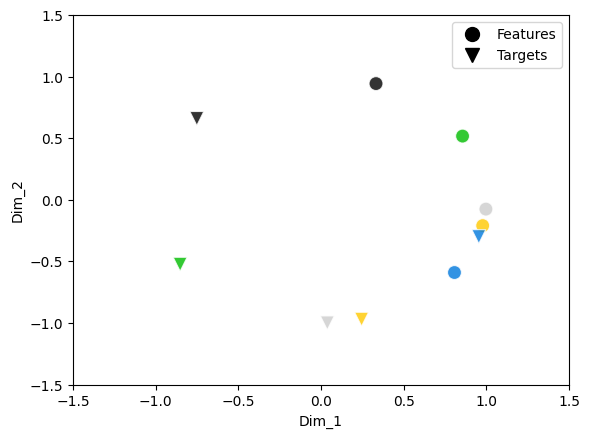

In [31]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])

## Learning curve

In [32]:
from estimators import TargetEstimator
from utils_v import gather_feats_targets

X_train, y_train = gather_feats_targets(model, std_train_loader, device)
X_test, y_test = gather_feats_targets(model, std_test_loader, device)


In [33]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [34]:
estimator = TargetEstimator()

In [35]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


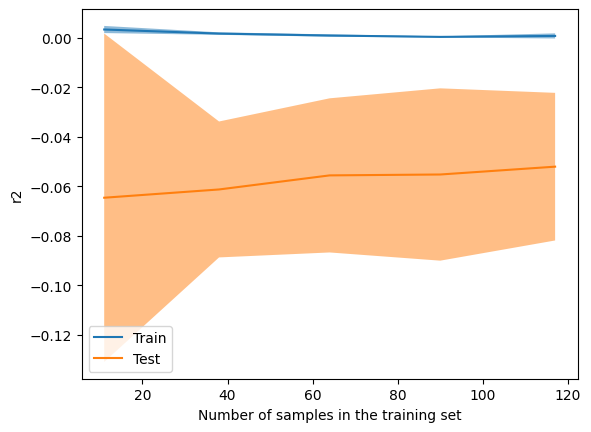

In [36]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
